# Getting Started with the `castor_etc` Python Package: Photometry

Isaac Cheng - April 2022

This notebook provides a brief overview of how to use the CASTOR exposure time calculator
(ETC) with some of the different source types: a point source, extended source, and a
galaxy. If you wish to use a custom surface brightness profile loaded from a FITS file,
please see the [`custom_source.ipynb`](./custom_source.ipynb) notebook for a demo of the
`CustomSource` class.

We always recommend reading the docstring of a class or function prior to using it.


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope


Check which version of the `castor_etc` package we are using.


In [2]:
from importlib.metadata import version
version("castor_etc")


'1.0.0'

## Preliminary information

In general, there are four basic steps to doing any photometry calculation with the
`castor_etc` Python package:

1. Describe the telescope
2. Characterize the sky background
3. Simulate a source
4. Specify a photometry aperture

Hence you will need some variation of the following imports:

```python
from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import CustomSource, ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope
```

There are other capabilities available in the `castor_etc` package (e.g., see the
`conversions` module), but these are not necessary to perform a photometry calculation.


## Point Source


### Describe the telescope

First, we specify the telescope parameters by creating a `Telescope` object. All aspects
of the telescope are customizable. This includes, but is not limited to, the number and
name of passbands, passband response curves and the passband limits, the full width at
half-maximum of the telescope's point spread function, pixel scale, read noise, extinction
coefficients of each passband, etc. Given some passband response curve, the photometric
zero-point and pivot wavelength are calculated automatically.

For convenience, each `Telescope` object is initialized with sensible default values
according to the most up-to-date information available at the time. These parameters are
maintained and updated in a central file. If the user needs to modify any telescope
parameters, it is recommended to pass in just the modified value(s) to a particular
`Telescope` instance rather than modifying the source file directly. If multiple
parameters need to be set each time, the user can store the parameters in a dictionary and
use Python's dictionary unpacking (e.g., `**kwargs`) to automatically populate the
relevant fields.

This means that, theoretically, this package can be used for other missions as long as the
telescope detector is CCD- or CMOS-based (or at least somewhat similar in the sense that
you can characterize read noise, dark current, etc.).


In [3]:
# For now, just use default telescope parameters
MyTelescope = Telescope()

# (Example) To specify a new detector read noise:
# MyTelescope = Telescope(readnoise=1.0)  # electron/pixel


### Characterize the sky background

The sky background is characterized by three parameters: Earthshine, zodiacal light, and
geocoronal emission (aka airglow). By default, the `Background` object uses spectra from
HST that give average Earthshine and zodiacal light values. Users can also input their own
Earthshine or zodiacal light spectra. Alternatively, they can describe the background
conditions by specifying the sky background AB magnitudes per square arcsecond in each
passband, which will take precedence over any spectrum files. Note that these AB
magnitudes should include the effects of both Earthshine and zodiacal light.


In [4]:
# Use default sky background values below
MyBackground = Background()


This background object currently does not have any geocoronal emission lines added to it.

Users can add an arbitrary amount of geocoronal emission lines. For convenience, we set
the default airglow value to represent the O[II] 2471A emission line, which is centred at
2471 angstrom with a linewidth of 0.023 angstrom. There are three predefined flux values
(in units of erg/cm^2/s/arcsec^2): "high" ($3.0\times10^{-15}$), "avg"
($1.5\times10^{-15}$), and "low" ($7.5\times10^{-17}$). As usual, users can specify their
own numeric values of flux, wavelength, and linewidth for each geocoronal emission line.

Suppose we are expecting high levels of airglow for our observation. We will add a O[II]
2471A geocoronal emission line to reflect this information below.


In [5]:
MyBackground.add_geocoronal_emission(flux="high")
# Remember that the default wavelength and linewidth are for the O[II] 2471A emission line


Let's visualize our sky background (excluding geocoronal emission) below. We will also
calculate the sky background AB magnitudes per square arcsecond in each passband, again
only including Earthshine and zodiacal light.

As a final note, we assume uniform sky background over our aperture. Note, however, that
we can specify spatially non-uniform backgrounds, pixel-by-pixel, in our `Photometry`
object (discussed below). For example, you might wish to multiply each pixel's sky
background by some random value sampled from a Normal distribution. We will not be showing
this here as it is outside the scope of this demonstration, but please feel free to reach
out if you have any questions about this.


In [6]:
print(MyBackground.earthshine_wavelengths.min())

1000.0


Average sky background AB magnitudes per sq. arcsec: {'uv': 27.727481682306795, 'u': 24.241956087315337, 'g': 22.588208427289167}


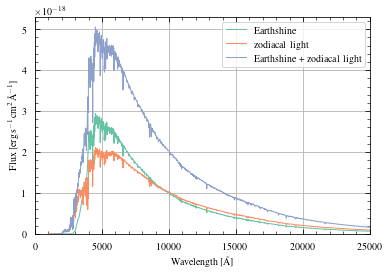

In [7]:
#
# Visualize the Earthshine + zodiacal light spectra. Note that _all_ of this code is only
# to plot the spectra and that this is absolutely not a required step in using the ETC...
#
fig, ax = plt.subplots()
ax.plot(
    MyBackground.earthshine_wavelengths,
    MyBackground.earthshine_flam,
    lw=1,
    label="Earthshine",
)
ax.plot(
    MyBackground.zodi_wavelengths,
    MyBackground.zodi_flam,
    lw=1,
    label="zodiacal light",
)
# Since these two spectra have the same wavelength grid, we can simply add them together
# to get the total Earthshine + zodiacal light spectrum. If th|eir wavelength grids are
# different, we can use interpolation (e.g., from `scipy`) to make them the same.
ax.plot(
    MyBackground.earthshine_wavelengths,
    (MyBackground.earthshine_flam + MyBackground.zodi_flam),
    lw=1,
    label="Earthshine + zodiacal light",
)
ax.set_xlabel(r"Wavelength [\AA]")
ax.set_ylabel(r"Flux [$\rm erg\,s^{-1}\,cm^2\,$\AA$^{-1}$]")
ax.legend()
ax.set_xlim(0, 25000)
ax.set_ylim(bottom=0)
#
# Find the sky background AB magnitudes per square arcsecond in each telescope passband
#
print(
    "Average sky background AB magnitudes per sq. arcsec:",
    MyBackground.calc_mags_per_sq_arcsec(MyTelescope),
)


### Simulate the source

In general, the creation of any `Source` object has three steps:

- Determining the type of the source (i.e., a point source, an extended source like a
  diffuse nebula, a galaxy, etc.)
- Describing the physical properties of the source, such as its spectrum (including any
  emission/absorption lines), the surface brightness profile of an extended source or
  galaxy, its redshift, distance, etc. Not all of these parameters need to be specified
  depending on your source.
- (Optional) Renormalizing the source spectrum. There are many normalization schemes
  available (e.g., normalize to an AB magnitude within a passband, normalize to a total
  luminosity and distance). Note that these normalizations can be applied at any time
  (e.g., can be before or after the addition of spectral lines).


We currently support generating the following spectra (the choice of spectra is agnostic
to the source type):
  - blackbody
  - power-law
  - emission line
  - uniform (i.e., flat), in units of erg/s/cm$^2$/A or erg/s/cm$^2$/Hz or AB magnitude or
    ST magnitude

Users can use their own spectra if available (see the `use_custom_spectrum()` docstring
for more details). Stellar spectra from the Pickles spectral library are also available
(see the `use_pickles_spectrum()` docstring for more details). Likewise, a generic
spectrum representing a spiral and elliptical galaxy are available from via the
`use_galaxy_spectrum()` method.

Let us simulate a star as a blackbody point source.


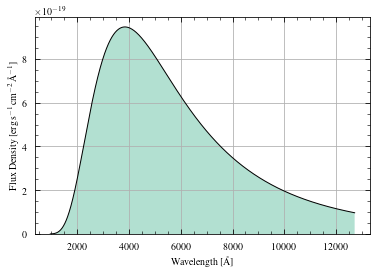

In [8]:
#
# Create point source
#
MySource = PointSource()
#
# Approximate the star as a blackbody with a temperature of 8000 K. By default, the
# spectral radiance of the blackbody (erg/s/cm^2/A/sr) is normalized to a star of 1 solar
# radius at 1 kpc distance to get the flux density in erg/s/cm^2/A (this can be changed
# via the `radius` and `dist` parameters).
# Note that only the temperature is required below, but some others are shown for
# illustration.
#
MySource.generate_bb(8000 * u.K, redshift=0.06)
#
# Renormalize the spectrum so it has a bolometric AB magnitude of 25.
# Note that bolometric AB magnitudes assume perfect telescope detector response over the
# whole spectrum. Please read the docstring for this function for more details.
#
MySource.norm_to_AB_mag(25)
#
# Visualize the spectrum
#
MySource.show_spectrum()


For fun, let us add some (weirdly broad) spectral lines to this spectrum!

The `abs_peak` and `abs_dip` flags denote whether the peak/dip of the spectral line should
include the continuum (`True`) or should be added/subtracted on top of the continuum
(`False`).


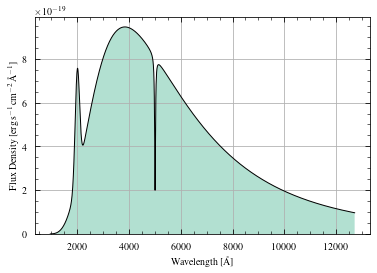

In [9]:
#
# Add emission and absorption lines. These spectral lines will always be well-sampled and
# the continuum spectrum does not necessarily have to be equally-spaced (in fact, no
# calculation in the ETC, at any point, assumes that any spectrum is equally-spaced). Note
# that you can also specify the total flux (in erg/s/cm^2) of the spectral line in lieu of
# the specifying its value at the peak/dip
#
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
#
# Visualize the spectrum with the emission and absorption lines added
#
MySource.show_spectrum()


### Do photometry

Finally, we will do the point-source photometry by specifying properties in a `Photometry`
object.

The most important part is specifying an aperture. So far, options include:

- optimal aperture (point sources only),
- elliptical aperture, and
- rectangular aperture.

Each of these apertures can be further customized. In the future, we may add an annular
aperture.


We will use an optimal aperture, which by default is a circular aperture with a diameter
equal to $1.4\times$ the FWHM of the telescope's PSF. Currently, the encircled energy
calculation assumes the telescope's PSF is described by a Gaussian.

We also use fractional pixel weights when simulating our source through the photometry
aperture. That is, we calculate the fractional overlap between the aperture and each
pixel. The sum of this aperture mask gives the "effective number of aperture pixels".
Confused? More details and a more obvious example of this being applied will be described
in the `Extended Source` section below.


INFO: Point source encircled energy = 74.30%
INFO: Note that, while these weights are useful in visualizing the point source, changing the source weights for a point source will not affect the final photometry calculation (again, only for point sources).
      Instead, set the `encircled_energy` parameter in the `calc_snr_or_t()` method to affect the signal-to-noise or integration time calculations.
      You can silence this message by setting `quiet=True`.


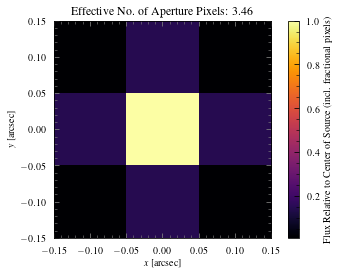

In [10]:
#
# Create Photometry object
#
MyPhot = Photometry(MyTelescope, MySource, MyBackground)
#
# Specify the aperture
#
MyPhot.use_optimal_aperture()  # warning messages can be silenced using quiet=True
#
# Show the source as viewed through the aperture
#
MyPhot.show_source_weights(quiet=False)


Users can change the number of aperture pixels used in the signal-to-noise (S/N) ratio
calculation if they desire. Again by default, this is the "effective number of aperture
pixels"; see the `calc_snr_or_t()` method docstring for more details. Note that read noise
is calculated to always be for an integer number of pixels (i.e., `ceil(number of pixels
in aperture)`).


Remember that this spectrum is normalized such that it's continuum spectrum has a
bolometric AB magnitude of 25. We then added emission and absorption lines on top of the
spectrum.

Let's see what is the AB magnitude in each of the telescope's passbands.


In [11]:
# 
# Calculate the AB magnitude in each of the telescope's passbands
# 
print(MySource.get_AB_mag(MyTelescope))

{'uv': 26.48447521335948, 'u': 25.009859663770023, 'g': 24.436980069771785}


Now find the time required to achieve a signal-to-noise ratio (SNR) of 10 in each
passband and verify that these integration times produce an SNR of 10.

Let's say that the *E(B-V)* value for this telescope pointing is 0.01.


In [12]:
TARGET_SNR = 10
REDDENING = 0.01  # E(B-V)

# (By default, returns a dictionary with the passbands as the keys)
# times = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)
# print(f"Time (s) required to reach SNR={TARGET_SNR} in each passband:", times)

# (For prettier printing)
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()


Time (s) required to reach SNR=10 in uv-band 1286.5933347126713
SNR achieved in t=1286.5933347126713 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 259.6774851312031
SNR achieved in t=259.6774851312031 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 138.60227018789146
SNR achieved in t=138.60227018789146 seconds in g-band 10.0



## Extended Source

We will be brief in our description of some steps below since much of the procedure
overlaps with the previous point source demonstration.


In [13]:
#
# Define telescope instance with a custom dark current
#
MyTelescope = Telescope(dark_current=0.01)  # dark current in electron/s per pixel


Suppose we know the sky background surface brightness in this particular area of the sky.
We can easily specify this in our background object, overriding any internal values.


In [14]:
#
# Generate background object
#
MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})


Now we will create an extended source. By default, there are two surface brightness
profiles available: "uniform" and "exponential". A uniform profile results in a constant
surface brightness over an elliptical region and the surface brightness drops to zero
immediately outside this ellipse. In contrast, an exponential profile is defined by its
scale lengths along the semimajor and semiminor axes, and the surface brightness smoothly
decreases from the centre of the source to infinity.

Additionally, a user can supply a function that describes some arbitrary surface
brightness profile. Please see the `ExtendedSource` docstring for more details on the
different `profile` options.

If the user wants to supply a surface brightness profile from a FITS file, then please use
the `CustomSource` class and see the [`custom_source.ipynb`](./custom_source.ipynb)
notebook.


In [15]:
#
# Create an extended source
#
MySource = ExtendedSource(
    angle_a=3 * u.arcsec,  # semimajor axis
    angle_b=1 * u.arcsec,  # semiminor axis
    rotation=45,  # CCW angle relative to x-axis
    profile="uniform",  # "uniform" or "exponential" or a function
)
# Both a uniform surface brightness & exponentially-decaying surface brightness
# (characterized by scale lengths) are available


Suppose the source is akin to a supernova remnant, where the continuum is very low. We can
approximate the spectrum as a single emission line in this case.


Source AB mags {'uv': 31.456637102948285, 'u': 38.99611850106819, 'g': 23.999999999999993}
Source bolometric AB mag 26.292065967816548


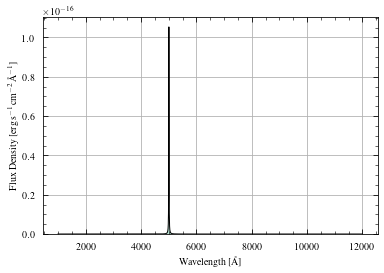

In [16]:
#
# Generate an emission line spectrum (e.g., O[III] emission line)
#
MySource.generate_emission_line(
    center=5007 * u.AA,
    fwhm=10 * u.AA,
    peak=7e-21,  # will be renormalized
    shape="lorentzian",
)
#
# Renormalize the spectrum to an AB magnitude of 24 in the telescope's g-band.
# Note that the spectral flux density is very close to zero in the UV- and u-bands, hence
# the AB magnitude in these bands are very large (i.e., very dim)
#
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
print("Source AB mags", MySource.get_AB_mag(MyTelescope))
print("Source bolometric AB mag", MySource.get_AB_mag())
#
# View the spectrum
#
MySource.show_spectrum()


This time, let's use a rectangular photometry aperture. We can also set the aperture
centre to be displaced from the source centre. The `center` parameter specifies the
position of the aperture centre relative to the source centre. By default, all apertures
are centred on the source.

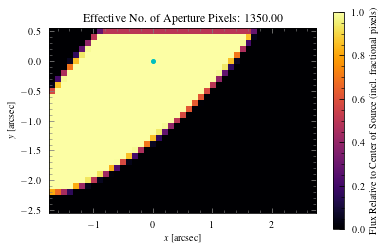

In [17]:
#
# Specify off-centre rectangular photometry aperture
#
MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=4.5 * u.arcsec, length=3 * u.arcsec, center=[0.5, -1] * u.arcsec
)
#
# Visualize the source through the aperture
# (Recall that this extended source has a uniform surface brightness profile)
#
MyPhot.show_source_weights(mark_source=True)


Now we will plot the aperture mask, which shows the fraction of each pixel that is
contained within the chosen aperture.


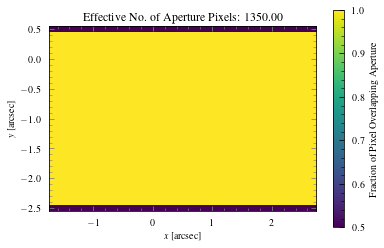

In [18]:
# 
# Notice the fractional pixel weights
# 
MyPhot.show_aper_weights()

Like before, we will find the integration time required to reach a signal-to-noise ratio
of 10.

Remember that the flux is very close to zero in the UV- and u-bands, so you should
disregard the results of these two passband calculations. In some cases, the emission line
spectrum may be so small in some passbands that Python will calculate the AB magnitude to
be infinity (since the negative logarithm of zero is positive infinity) and will output a
`RuntimeWarning`. In these cases, if you want to avoid all of these warnings, you can
generate a spectrum with a low but non-zero continuum (e.g., $10^{-21}$ erg/s/cm$^2$/A)
and add an emission line on top of this continuum.


In [19]:
TARGET_SNR = 10
REDDENING = 0

# (For prettier printing)
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

Time (s) required to reach SNR=10 in uv-band 1869227101.7863188
SNR achieved in t=1869227101.7863188 seconds in uv-band 10.000000000000002

Time (s) required to reach SNR=10 in u-band 4386212301638457.5
SNR achieved in t=4386212301638457.5 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 8057.3493988938635
SNR achieved in t=8057.3493988938635 seconds in g-band 9.999999999999998



## Galaxy Source

Finally, we will simulate a galaxy using the `castor_etc` package.


As always, we begin with defining our telescope parameters.


In [20]:
#
# Define telescope instance
#
MyTelescope = Telescope()


Here, we assume default levels of Earthshine and zodiacal light, but we add a custom
geocoronal emission line.


In [21]:
#
# Generate background object
#
MyBackground = Background()  # default Earthshine and zodiacal light
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

Now we make a galaxy with a typical de Vaucouleurs profile (Sérsic index $n=4$). Another
common Sérsic index value is $n=1$, which denotes an exponentially-decreasing profile.


In [22]:
#
# Make a galaxy with a de Vaucouleurs profile
#
MySource = GalaxySource(
    r_eff=3 * u.arcsec,  # effective radius, sqrt(a * b)
    n=4,  # Sersic index
    axial_ratio=0.9,  # ratio of semiminor axis (b) to semimajor axis (a)
    rotation=135,  # CCW rotation from x-axis
)


Let's use one of the predefined spectra to describe this galaxy. As well, we are going to
renormalize the spectrum to some total (bolometric) luminosity and distance. Finally,
suppose it is an intermediate-redshift galaxy ($z=0.1$).


Source AB mags {'uv': 18.766037134742582, 'u': 18.135325977918022, 'g': 16.711046696960473}
Source bolometric AB mag 16.458904724098822


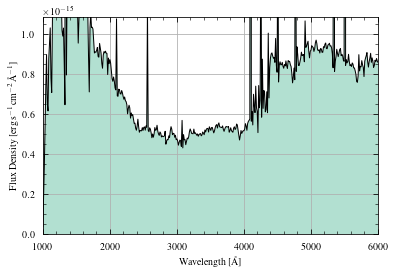

In [23]:
#
# Choose a generic spiral galaxy spectrum & renormalize to some bolometric luminosity +
# distance
#
MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)  # (solar luminosities)
#
# Redshift wavelengths
#
MySource.redshift_wavelengths(0.1)
print("Source AB mags", MySource.get_AB_mag(MyTelescope))
print("Source bolometric AB mag", MySource.get_AB_mag())
#
# Visualize spectrum
#
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()


We will use an elliptical photometry aperture for this calculation.


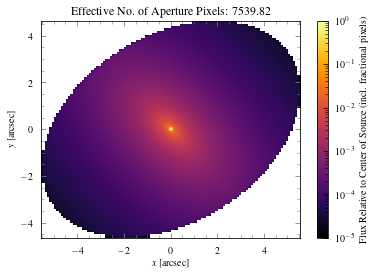

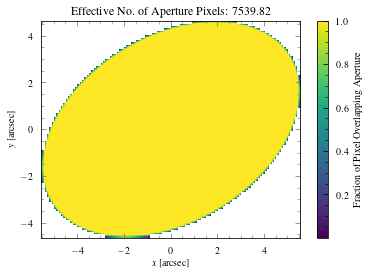

In [24]:
#
# Specify photometry aperture
#
MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=6 * u.arcsec, b=4 * u.arcsec, center=[0, 0] * u.arcsec, rotation=31.41592654
)
#
# Visualize source and aperture
#
MyPhot.show_source_weights(norm=LogNorm(vmin=1e-5, vmax=1))
MyPhot.show_aper_weights()


Finally, let's find the signal-to-noise ratio achieved after 4321 seconds. Bonus fact:
this integration time is actually my bank account PIN! (Just kidding...)


In [25]:
INTEGRATION_TIME = 4321  # seconds
REDDENING = 0.01  # E(B-V)

# (For prettier printing)
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING)[band]
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()


SNR achieved in t=4321 seconds in uv-band 3.2362958717278723
Time (s) required to reach SNR=3.2362958717278723 in uv-band 4320.999999999998

SNR achieved in t=4321 seconds in u-band 3.6315683999843174
Time (s) required to reach SNR=3.6315683999843174 in u-band 4320.999999999999

SNR achieved in t=4321 seconds in g-band 7.26451205815471
Time (s) required to reach SNR=7.26451205815471 in g-band 4321.0

